# Anomaly Detection From Scratch
I'll implement the anomaly detection algorithm and apply it to detect failing servers on a network

## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 2 - Anomaly detection

### 2.1 Problem Statement

I will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* I suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

I will use a Gaussian model to detect anomalous examples in
dataset. 
* I will first start on a 2D dataset that will allow to visualize what the algorithm is doing.
* On that dataset I will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 
* After that, I will apply the anomaly detection algorithm to a larger dataset with many dimensions. 


### 2.2  Dataset

I will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into the variables `X_train`, `X_val` and `y_val` 
    - I will use `X_train` to fit a Gaussian distribution 
    - I will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [2]:
#load data
X_train = np.load('/kaggle/input/datadummy/X_part1.npy')
X_val = np.load('/kaggle/input/datadummy/X_val_part1.npy')
y_val = np.load('/kaggle/input/datadummy/y_val_part1.npy')

In [3]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [4]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5])  

The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [5]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5])  

The first 5 elements of y_val are
 [0 0 0 0 0]


#### Check the dimensions of variables

Another useful way to get familiar with your data is to view its dimensions.

The code below prints the shape of `X_train`, `X_val` and `y_val`.

In [6]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


Visualize data

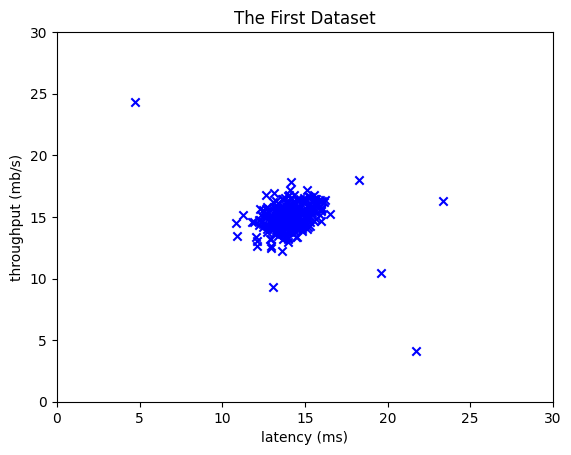

In [7]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')

plt.title('The First Dataset')
plt.ylabel('throughput (mb/s)')
plt.xlabel('latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

<a name="2.3"></a>
### 2.3 Gaussian distribution

To perform anomaly detection, I will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).


the `estimate_gaussian` function below to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

I can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, I will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance I will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$


In [8]:
def estimate_gaussian(X):
    m,n = X.shape

    mu = 1/m * np.sum(X, axis = 0)
    var = 1/m * np.sum((X - mu)**2, axis = 0)

    return mu,var

In [9]:
mu, var = estimate_gaussian(X_train)
print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


**visualize the contours of the fitted Gaussian distribution.**

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Compute probabilitas density from X_train
p = multivariate_normal.pdf(X_train, mean=mu, cov=np.diag(var))

# Visualize fit Gaussian
def visualize_fit(X, mu, var):
    x = np.linspace(0, 30, 100)
    y = np.linspace(0, 30, 100)
    X1, X2 = np.meshgrid(x, y)
    grid = np.column_stack((X1.ravel(), X2.ravel()))
    Z = multivariate_normal.pdf(grid, mean=mu, cov=np.diag(var))
    Z = Z.reshape(X1.shape)

    plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', label='Data')
    contour_levels = [10**exp for exp in range(-20, 0, 3)]
    plt.contour(X1, X2, Z, levels=contour_levels, cmap='viridis')

    plt.title('Gaussian Contours of the distribution fit to the dataset')
    plt.xlabel('latency (ms)')
    plt.ylabel('throughput (mb/s)')
    plt.axis([0, 30, 0, 30])
    plt.grid(True)

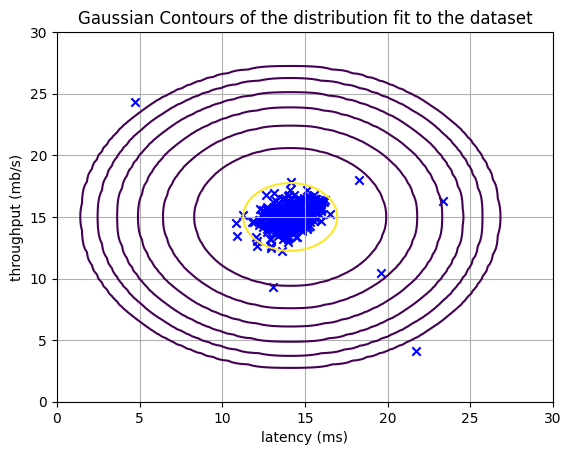

In [34]:
Visualize_fit(X_train, mu, var)
plt.show()

### 2.3.2 Selecting the threshold $\epsilon$

Now that I have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, I will complete the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.


the `select_threshold` function below to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* In the provided code `select_threshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 

* You need to implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

**Implementation Note:** 
In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples.

In [17]:
def select_threshold(y_val, p_val):

    best_epsilon = 0
    best_F1 = 0
    F1 = 0 

    step_size = (max(p_val) - min(p_val)) / 1000
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        
        predictions = (p_val < epsilon)
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        prec = tp / (tp+fp)
        rec = tp / (tp+fn)
        F1 = 2 * prec * rec / (prec + rec)

        if F1 > best_F1 :
            best_F1 = F1 
            best_epsilon = epsilon
            
    return best_epsilon, best_F1

In [18]:
p_val = multivariate_normal.pdf(X_val, mean=mu, cov=np.diag(var))

epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


/tmp/ipykernel_31/626032357.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp+fp)


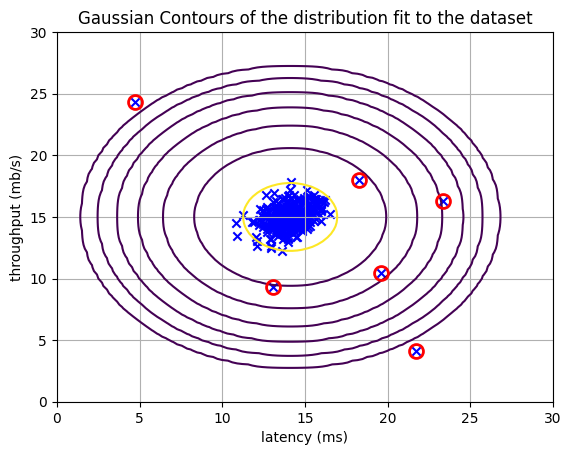

In [35]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize=10, markerfacecolor='none', markeredgewidth=2,
         label='Outliers')

plt.show()


<a name="2.4"></a>
### 2.4 High dimensional dataset

Now,  we will run the anomaly detection algorithm that you implemented on a more realistic and much harder dataset.

In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

Let's start by loading the dataset.

- The `load_data()` function shown below loads the data into variables `X_train_high`, `X_val_high` and `y_val_high`
    -  `_high` is meant to distinguish these variables from the ones used in the previous part
    - We will use `X_train_high` to fit Gaussian distribution 
    - We will use `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [38]:
#load data
X_train_high = np.load('/kaggle/input/datadummy/X_part2.npy')
X_val_high = np.load('/kaggle/input/datadummy/X_val_part2.npy')
y_val_high = np.load('/kaggle/input/datadummy/y_val_part2.npy')

#### Check the dimensions of variables

Let's check the dimensions of these new variables to become familiar with the data

In [39]:
print ('The shape of X_train is:', X_train_high.shape)
print ('The shape of X_val is:', X_val_high.shape)
print ('The shape of y_val is: ', y_val_high.shape)

The shape of X_train is: (1000, 11)
The shape of X_val is: (100, 11)
The shape of y_val is:  (100,)


#### Anomaly detection 

Now, let's run the anomaly detection algorithm on this new dataset.

The code below will use your code to 
* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train_high` from which I estimated the Gaussian parameters, as well as for the the cross-validation set `X_val_high`. 
* Finally, it will use `select_threshold` to find the best threshold $\varepsilon$. 

In [40]:
# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_normal.pdf(X_train_high, mean=mu_high, cov=np.diag(var_high))

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_normal.pdf(X_val_high, mean=mu_high, cov=np.diag(var_high))

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


/tmp/ipykernel_31/626032357.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp+fp)


<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 1.38e-18</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.615385 </td> 
  </tr>
    <tr>
    <td> <b># anomalies found: <b>  </td>
     <td>  117 </td> 
  </tr>
</table>